In [ ]:
# Libraries and presets
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing the dataset
ticker = 'XLP'
df_week = yf.download(ticker, interval='1wk')
df_week = df_week.xs(ticker, level='Ticker', axis=1)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Features
rsi = ta.momentum.RSIIndicator(df_week['Close'], window = 2)
df_week['RSI'] = rsi.rsi()

df = yf.download(ticker)
df = df.xs(ticker, level='Ticker', axis=1)

df = pd.merge_asof(df, df_week[['RSI']], on='Date', direction='backward')

df.set_index('Date', inplace=True)

df['Weekday'] = df.index.weekday

df.dropna(axis=0, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Trading rules
df['Entry_Signal'] = np.nan
df['Exit_Signal'] = np.nan

aux = 0

for i in range(len(df)):
  if aux == 0 and df.iloc[i]['RSI'] <= 15 and df.iloc[i]['Weekday'] == 4:
    df.iloc[i, df.columns.get_loc('Entry_Signal')] = 1
    aux = 1
  if aux == 1 and df.iloc[i]['RSI'] >=20:
    df.iloc[i, df.columns.get_loc('Exit_Signal')] = 1
    aux = 0

In [ ]:
# Filtering only the signals to calculate returns
df = df.dropna(subset = ['Entry_Signal', 'Exit_Signal'], axis=0, how='all')

# Checking if there is no open trade without closing
if df['Entry_Signal'].sum() > df['Exit_Signal'].sum():
  df.drop(df.index[-1], inplace=True)

In [ ]:
# Calculating trade returns
df['Trade'] = df['Close'].pct_change(1)
df['Acc_trade'] = df['Trade'].cumsum() * 100

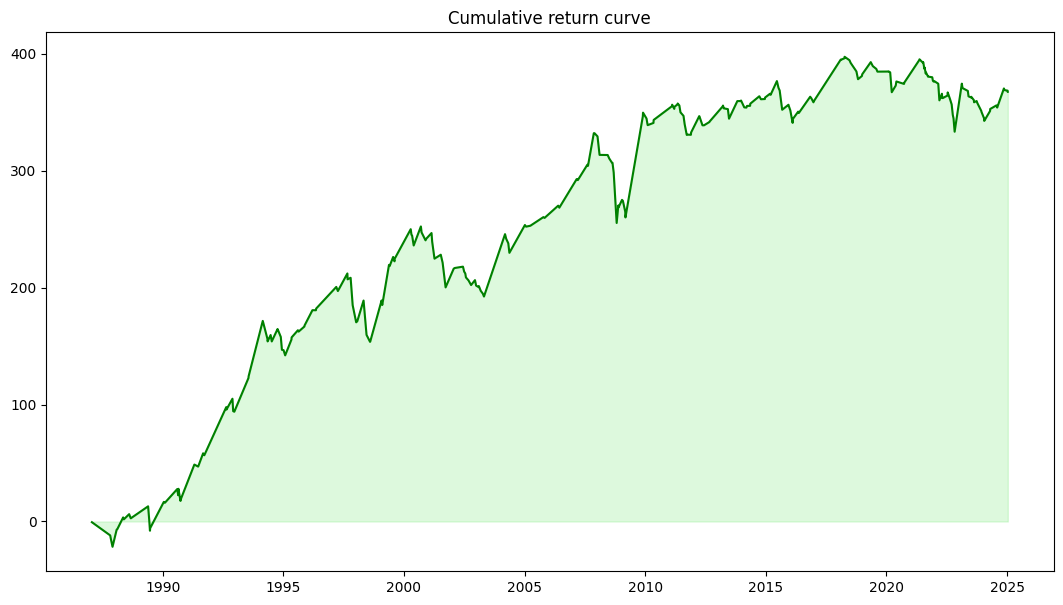

In [ ]:
# Plotting the cumulative return curve
plt.figure(figsize=(13,7))
plt.plot(df['Acc_trade'], color='green')
plt.fill_between(df.index, df['Acc_trade'], alpha=0.3, color='lightgreen')
plt.title('Cumulative return curve')
plt.show()